In [1]:
import sys
sys.path.append("..")
from MPRA_predict.utils import *
from MPRA_predict.datasets import *
from MPRA_predict.metrics import *

In [2]:
MPRA_df = pd.read_csv('../data/Gosai_MPRA/Gosai_MPRA_Enformer_feature_0504.csv')
MPRA_df

,seq,ID,chr,pos,ref_allele,alt_allele,allele,OL,data_project,K562,HepG2,SK-N-SH,A549,HCT116,K562_DNase,K562_H3K4me3,K562_H3K27me3,K562_H3K4me1,K562_H3K36me3,K562_H3K9me3,K562_CTCF,HepG2_DNase,HepG2_H3K4me3,HepG2_H3K27me3,HepG2_H3K4me1,HepG2_H3K36me3,HepG2_H3K9me3,HepG2_CTCF,SK-N-SH_DNase,SK-N-SH_H3K4me3,SK-N-SH_H3K27ac,SK-N-SH_H3K27me3,SK-N-SH_H3K4me1,SK-N-SH_H3K36me3,SK-N-SH_H3K9me3,SK-N-SH_CTCF,HCT116_DNase,HCT116_H3K4me3,HCT116_H3K27ac,HCT116_H3K27me3,HCT116_H3K4me1,HCT116_H3K36me3,HCT116_H3K9me3,HCT116_CTCF,A549_DNase,A549_H3K4me3,A549_CTCF,K562_H3K27ac,HepG2_H3K27ac,A549_H3K27ac,A549_H3K27me3,A549_H3K4me1,A549_H3K36me3,A549_H3K9me3
0,AGTGCTGGTTCCGTCACCCCCTCCCAAGGAAGTAGGTCTGAGCAGC...,1:14677:G:A:A:wC,chr1,14677,G,A,alt,OL41_42,GTEx,0.014,-0.054,0.012,NaN,-0.709,0.082,0.682,1.078,3.238,1.168,0.860,1.123,0.272,0.605,0.681,0.715,1.879,0.781,1.102,0.131,0.637,0.744,0.913,1.453,1.293,0.935,0.894,0.087,0.704,1.485,0.729,1.389,1.605,1.075,0.998,0.144,0.304,1.092,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AGTGCTGGTTCCGTCACCCCCTCCCAAGGAAGTAGGTCTGAGCAGC...,1:14677:G:A:R:wC,chr1,14677,G,A,ref,OL41_42,GTEx,-1.042,0.183,0.094,NaN,-0.266,0.085,0.668,1.079,3.574,1.123,0.851,1.135,0.279,0.596,0.614,0.766,1.965,0.771,1.085,0.151,0.680,0.955,0.935,1.733,1.328,0.923,0.925,0.095,0.706,1.537,0.769,1.433,1.644,1.053,1.033,0.156,0.309,1.098,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CATACATTTTTATTCTGGTCACTGTCCAACGACATTCCTCAAATGA...,1:63697:T:C:A:wC,chr1,63697,T,C,alt,OL41_42,GTEx,-1.004,0.640,-0.188,NaN,0.619,0.048,0.638,1.514,0.319,0.892,1.641,0.938,0.060,0.592,1.427,0.518,0.690,2.527,1.100,0.039,0.875,1.815,1.131,1.625,1.552,1.791,1.100,0.110,0.880,1.006,1.352,1.502,1.488,1.745,1.126,0.066,0.274,1.010,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CATACATTTTTATTCTGGTCACTGTCCAACGACATTCCTCAAATGA...,1:63697:T:C:R:wC,chr1,63697,T,C,ref,OL41_42,GTEx,-0.779,0.751,0.274,NaN,0.668,0.056,0.654,1.568,0.356,0.936,1.596,1.023,0.065,0.606,1.577,0.638,0.756,1.587,1.188,0.048,0.939,3.291,1.087,1.905,1.715,1.789,1.207,0.139,0.939,1.271,1.322,1.982,1.704,1.768,1.203,0.083,0.281,1.071,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AATAGACTCTAGTACTCTGTATTATGCAAAATTTGTCTATGTTACA...,1:64764:C:T:R:wC,chr1,64764,C,T,ref,OL41_42,GTEx,-0.457,-0.645,0.061,NaN,-0.168,0.018,0.579,0.514,0.312,0.604,1.341,0.756,0.051,0.644,0.798,0.374,0.635,2.041,1.088,0.063,0.816,0.452,1.946,1.014,1.305,1.562,0.916,0.043,0.814,0.744,1.322,0.963,1.608,2.523,1.021,0.035,0.288,0.728,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
760674,CTGCATCTGTGCAGCCTGGCAGCGGCGGCGCTGCGCTGTGACATTT...,Y:15815629:NA:NA,chrY,15815629,NaN,NaN,NaN,OL15,OL15,0.708,1.294,1.077,NaN,NaN,0.103,1.596,6.055,6.330,0.894,1.387,1.809,0.171,0.790,3.852,0.531,0.843,1.012,1.396,0.268,1.266,3.910,2.299,3.264,1.272,1.167,1.566,0.054,0.738,1.843,3.035,1.803,1.162,1.203,1.338,0.093,0.338,1.395,NaN,NaN,NaN,NaN,NaN,NaN,NaN
760675,GCACTTCACATTTGTTTTTAGGGTTACATAGTCTACTCTGTATCCT...,Y:21740684:NA:NA,chrY,21740684,NaN,NaN,NaN,OL15,OL15,-0.708,-0.547,-0.429,NaN,NaN,0.042,0.653,1.294,0.503,1.101,1.281,1.050,0.096,0.670,1.047,0.656,1.008,1.539,1.345,0.105,1.089,0.837,1.748,2.110,1.506,1.652,1.192,0.086,0.804,1.090,1.726,1.518,1.455,1.311,1.213,0.060,0.338,1.190,NaN,NaN,NaN,NaN,NaN,NaN,NaN
760676,TGTTCAAGTGGCCACAGGGTTACTTGCTTTAGCATGGCTCCTTGGC...,Y:21740884:NA:NA,chrY,21740884,NaN,NaN,NaN,OL15,OL15,-0.146,-0.200,-0.310,NaN,NaN,0.035,0.656,1.553,0.359,0.783,1.179,0.953,0.106,0.707,1.820,1.705,0.801,1.350,1.248,0.080,1.133,2.773,1.363,2.562,1.756,1.584,1.236,0.133,1.026,0.966,3.973,1.602,1.668,3.094,1.170,0.113,0.520,0.949,NaN,NaN,NaN,NaN,NaN,NaN,NaN
760677,TAATTAGTTGGGAAGGTTCAGGTTCTGGGACATCCGTTGCTATTTC...,Y:21741084:NA:NA,chrY,21741084,NaN,NaN,NaN,OL15,OL15,-0.119,-0.090,-0.387,NaN,NaN,0.058,0.594,1.013,0.418,1.225,1.225,0.974,0.119,0.751,1.762,0.816,1.109,1.715,1.324,0.070,0.942,1.002,1.436,1.457,1.619

In [3]:
data_split_dict = {}
data_split_dict['total'] = np.ones(len(MPRA_df), dtype=bool)
data_split_dict['chrom'] = MPRA_df['chr'].isin([f'chr{i}' for i in (list(range(1, 23)) + ['X', 'Y'])])
data_split_dict['designed'] = ~data_split_dict['chrom']

data_split_dict['train'] = MPRA_df['chr'].isin([f'chr{i}' for i in (list(range(3, 23)) + ['X', 'Y'])])
data_split_dict['valid'] = MPRA_df['chr'].isin(['chr1'])
data_split_dict['test'] = MPRA_df['chr'].isin(['chr2'])

data_split_dict['ref'] = (MPRA_df['allele'] == 'ref') | (MPRA_df['allele'].isna())
data_split_dict['alt'] = MPRA_df['allele'] == 'alt'

In [4]:
cell_types = ['K562', 'HepG2', 'SK-N-SH', 'HCT116', 'A549']
assays = ['DNase', 'H3K4me3', 'H3K27ac', 'H3K27me3', 'H3K4me1', 'H3K36me3', 'H3K9me3', 'CTCF']

In [5]:
import numpy as np

def quantile_normalize(matrix):
    sorted_idx = np.argsort(matrix, axis=0)
    sorted_matrix = np.sort(matrix, axis=0)
    mean_ranks = np.mean(sorted_matrix, axis=1)

    normalized = np.zeros_like(matrix)
    for col in range(matrix.shape[1]):
        ranks = sorted_idx[:, col].argsort()
        normalized[:, col] = mean_ranks[ranks]
    return normalized

# 对每个 assay 分别归一化其对应的 cell type 列（跳过全 NaN 列）
for assay in assays:
    # 找出该 assay 下所有 cell type 的列名
    all_columns = [f'{cell_type}_{assay}' for cell_type in cell_types]

    # 仅保留非空列（即该 assay 在该 cell type 中存在）
    valid_columns = [col for col in all_columns if not MPRA_df[col].isna().all()]

    if len(valid_columns) <= 1:
        # 只有一个非空列或没有，跳过归一化（无需或无法做分位数标准化）
        continue

    # 构建归一化矩阵
    X = MPRA_df[valid_columns].copy().values  # shape: (num_samples, num_valid_columns)

    # 应用分位数归一化
    X_qn = quantile_normalize(X)

    # 写回原 DataFrame
    for i, col in enumerate(valid_columns):
        MPRA_df[col] = X_qn[:, i]


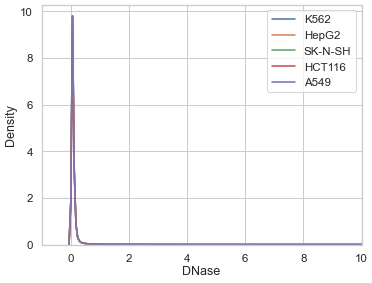

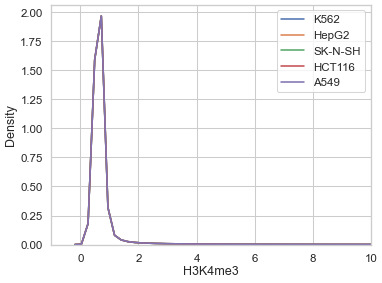

/tmp/ipykernel_121766/450871654.py:6: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x, label=cell_type)
/tmp/ipykernel_121766/450871654.py:6: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x, label=cell_type)
/tmp/ipykernel_121766/450871654.py:6: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x, label=cell_type)


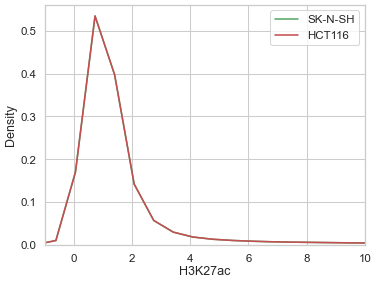

/tmp/ipykernel_121766/450871654.py:6: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x, label=cell_type)


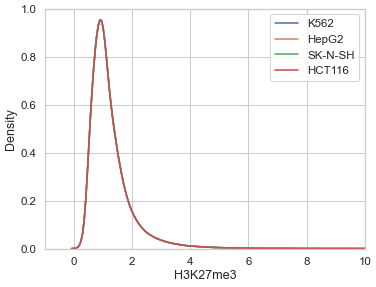

/tmp/ipykernel_121766/450871654.py:6: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x, label=cell_type)


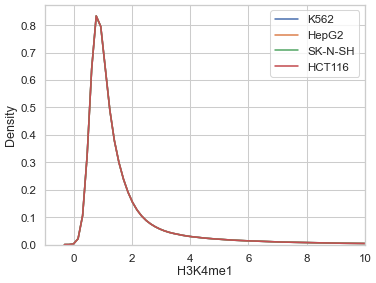

/tmp/ipykernel_121766/450871654.py:6: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x, label=cell_type)


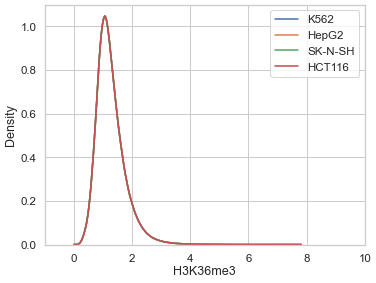

/tmp/ipykernel_121766/450871654.py:6: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x, label=cell_type)


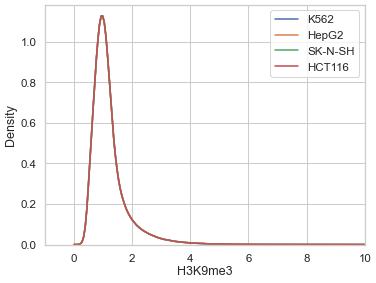

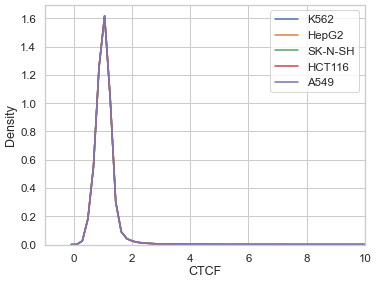

In [6]:
for j, assay in enumerate(assays):
    plt.figure(figsize=(8, 6), dpi=50)
    plt.subplots_adjust(left=0.15, bottom=0.15, right=0.95, top=0.95)
    for i, cell_type in enumerate(cell_types):
        x = MPRA_df[f'{cell_type}_{assay}']
        sns.kdeplot(x, label=cell_type)
    plt.xlim(-1, 10)
    plt.xlabel(f'{assay}')
    plt.legend()
    # plt.savefig(f'figures/Gosai_MPRA_Sei_{assay}_distribution_norm.png', dpi=400)
    plt.show()

In [ ]:
def quantile_normalize(matrix):
    sorted_mat = np.sort(matrix, axis=0)
    mean_ranks = np.mean(sorted_mat, axis=1)
    ranks = np.argsort(np.argsort(matrix, axis=0), axis=0)
    norm_matrix = np.zeros_like(matrix)
    for i in range(matrix.shape[1]):
        norm_matrix[:, i] = mean_ranks[ranks[:, i]]
    return norm_matrix


In [ ]:
from scipy.stats import norm, rankdata

def quantile_to_normal(data):
    ranks = rankdata(data)
    quantiles = ranks / (len(data) + 1)
    return norm.ppf(quantiles)

In [ ]:
# for j, assay in enumerate(assays):
#     plt.figure(figsize=(8, 6), dpi=50)
#     plt.subplots_adjust(left=0.15, bottom=0.15, right=0.95, top=0.95)
#     for i, cell_type in enumerate(cell_types):
#         x = MPRA_df[f'{cell_type}_{assay}']
#         sns.kdeplot(x, label=cell_type)
#     # plt.xlim(-0.5, 5)
#     plt.xlabel(f'{assay}')
#     plt.legend()
#     plt.savefig(f'figures/Gosai_MPRA_Enformer_{assay}_distribution.png', dpi=400)
#     plt.show()

In [ ]:
# # normalize between different cell types and assays

# for i, cell_type in enumerate(cell_types):
#     for j, assay in enumerate(assays):
#         x = MPRA_df[f'{cell_type}_{assay}'].copy()
#         print(f'{cell_type}_{assay}', x.mean(), x.max(), x.min())
#         condition = data_split_dict['train']
#         x_train = x[condition]

#         clip_threshold = np.percentile(x_train, 99)
#         print(clip_threshold)
#         x_clipped = np.minimum(x, clip_threshold)
        
#         x_train_clipped = x_clipped[condition]
#         clipped_mean = np.mean(x_train_clipped)
#         x_normalized = x_clipped / clipped_mean

#         MPRA_df[f'{cell_type}_{assay}'] = x_normalized

In [ ]:
# normalize between different cell types and assays

for i, cell_type in enumerate(cell_types):
    for j, assay in enumerate(assays):
        x = MPRA_df[f'{cell_type}_{assay}'].copy()
        print(f'{cell_type}_{assay}', x.mean(), x.max(), x.min())
        condition = data_split_dict['train']
        x_train = x[condition]

        train_median = x_train.median()
        x_normalized = x / train_median
        x_normalized = np.minimum(x_normalized, 10)

        # clip_threshold = np.percentile(x_train, 99)
        # print(clip_threshold)
        # x_clipped = np.minimum(x, clip_threshold)
        
        # x_train_clipped = x_clipped[condition]
        # clipped_mean = np.mean(x_train_clipped)
        # x_normalized = x_clipped / clipped_mean

        MPRA_df[f'{cell_type}_{assay}'] = x_normalized

In [ ]:
for j, assay in enumerate(assays):
    plt.figure(figsize=(8, 6), dpi=50)
    plt.subplots_adjust(left=0.15, bottom=0.15, right=0.95, top=0.95)
    for i, cell_type in enumerate(cell_types):
        x = MPRA_df[f'{cell_type}_{assay}']
        sns.kdeplot(x, label=cell_type)
    plt.xlim(-1, 10)
    plt.xlabel(f'{assay}')
    plt.legend()
    # plt.savefig(f'figures/Gosai_MPRA_Sei_{assay}_distribution_norm.png', dpi=400)
    plt.show()

In [ ]:
MPRA_df.to_csv('../data/Gosai_MPRA/Gosai_MPRA_Enformer_feature_0504_norm.csv', index=False)

In [ ]:
MPRA_df = pd.read_csv('../data/SirajMPRA/SirajMPRA_562654.csv')
MPRA_df

In [ ]:
plt.figure(figsize=(8, 6), dpi=50)
plt.subplots_adjust(left=0.15, bottom=0.15, right=0.95, top=0.95)
for i, cell_type in enumerate(cell_types):
    x = MPRA_df[cell_type]
    sns.kdeplot(x, label=cell_type)
plt.xlabel(f'exp')
plt.legend()
plt.show()

In [ ]:
# normalize between different cell types
MPRA_df_norm = MPRA_df.copy()

for i, cell_type in enumerate(cell_types):
    x = MPRA_df[cell_type].copy()
    condition = data_split_dict['train']
    x_mean = np.mean(x[condition])
    x_std = np.std(x[condition])
    x = (x - x_mean) / x_std
    MPRA_df_norm[cell_type] = x

In [ ]:
plt.figure(figsize=(8, 6), dpi=50)
plt.subplots_adjust(left=0.15, bottom=0.15, right=0.95, top=0.95)
for i, cell_type in enumerate(cell_types):
    x = MPRA_df_norm[cell_type]
    sns.kdeplot(x, label=cell_type)
plt.xlabel(f'exp')
plt.legend()
plt.show()

In [ ]:
MPRA_df_norm.to_csv('../data/SirajMPRA/SirajMPRA_562654_norm.csv', index=False)